# Financial News Sentiment Analysis Project
## Part 3: Naive Bayes + TF-IDF Model

This notebook implements the first baseline model:
1. Multinomial Naive Bayes
2. Based on TF-IDF features
3. Performance evaluation and visualization

## 1. Import Libraries & Load Data

In [17]:
import sys
import os
from pathlib import Path

# Setup project paths
current_dir = Path.cwd()

if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
else:
    project_root = Path('c:/Users/xuzijian/Desktop/新闻情感/project')

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import scipy.sparse as sp

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

from models import ModelEvaluator

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [18]:
# Load processed data
data_dir = project_root / 'data' / 'train_test'
if not data_dir.exists():
    data_dir = project_root.parent / 'data' / 'train_test'

# Load feature matrices
X_train = sp.load_npz(str(data_dir / 'X_train_tfidf.npz'))
X_val = sp.load_npz(str(data_dir / 'X_val_tfidf.npz'))
X_test = sp.load_npz(str(data_dir / 'X_test_tfidf.npz'))

# Load labels
y_train = np.load(str(data_dir / 'y_train.npy'))
y_val = np.load(str(data_dir / 'y_val.npy'))
y_test = np.load(str(data_dir / 'y_test.npy'))

# Load label encoder
label_encoder = joblib.load(str(project_root / 'models' / 'label_encoder.pkl'))
label_names = label_encoder.classes_

print(f"✓ Data loaded successfully")
print(f"  Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"  Labels: {label_names}")

✓ Data loaded successfully
  Train: (23500, 5000), Val: (2937, 5000), Test: (2938, 5000)
  Labels: ['negative' 'neutral' 'positive']


## 2. Train Naive Bayes Model

In [19]:
# Hyperparameter tuning: alpha
alpha_values = [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0]

results_dict = {}
best_f1 = 0
best_alpha = None
best_model = None

print("Tuning alpha parameter...")
for alpha in alpha_values:
    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train, y_train)
    
    y_val_pred = nb_model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    results_dict[alpha] = f1
    
    if f1 > best_f1:
        best_f1 = f1
        best_alpha = alpha
        best_model = nb_model

print(f"✓ Best alpha: {best_alpha} (F1={best_f1:.4f})")

Tuning alpha parameter...
✓ Best alpha: 0.05 (F1=0.6749)


In [20]:
# Make predictions with best model
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)

y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

# Save model
models_dir = project_root / 'models'
models_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(best_model, str(models_dir / 'naive_bayes_model.pkl'))
print(f"✓ Model saved to models/naive_bayes_model.pkl")

✓ Model saved to models/naive_bayes_model.pkl


## 3. Model Evaluation

In [21]:
# Calculate evaluation metrics
def evaluate_model(y_true, y_pred, y_proba, set_name='Test'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{set_name} Set:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Evaluate on all sets
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, 'Train')
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, 'Validation')
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, 'Test')


Train Set:
  Accuracy: 0.7073, Precision: 0.7094, Recall: 0.7073, F1: 0.7020

Validation Set:
  Accuracy: 0.6796, Precision: 0.6819, Recall: 0.6796, F1: 0.6749

Test Set:
  Accuracy: 0.6726, Precision: 0.6707, Recall: 0.6726, F1: 0.6655


In [22]:
# Classification report
print(f"\nTest Set - Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_names, zero_division=0))


Test Set - Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.47      0.53       675
     neutral       0.67      0.83      0.74      1097
    positive       0.71      0.64      0.67      1166

    accuracy                           0.67      2938
   macro avg       0.66      0.65      0.65      2938
weighted avg       0.67      0.67      0.67      2938



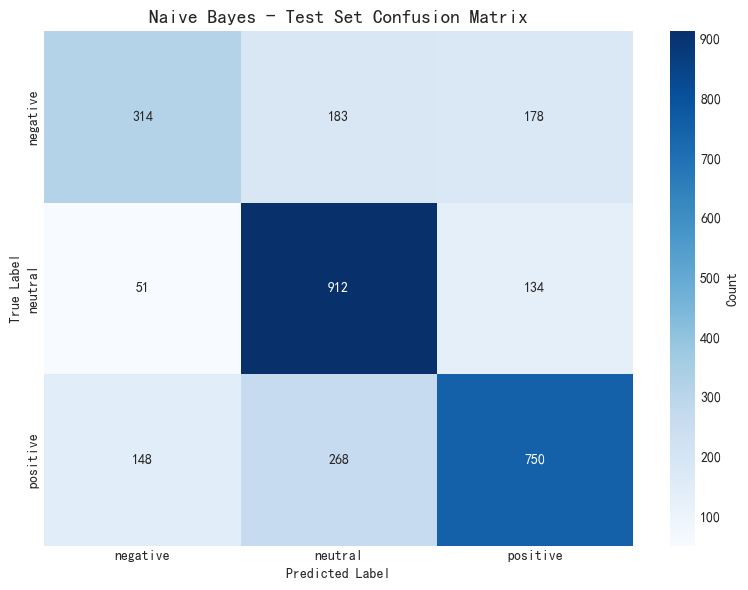

✓ Confusion matrix saved


In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_names, yticklabels=label_names,
           cbar_kws={'label': 'Count'})
plt.title('Naive Bayes - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

results_dir = project_root / 'results'
results_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(str(results_dir / 'cm_naive_bayes.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

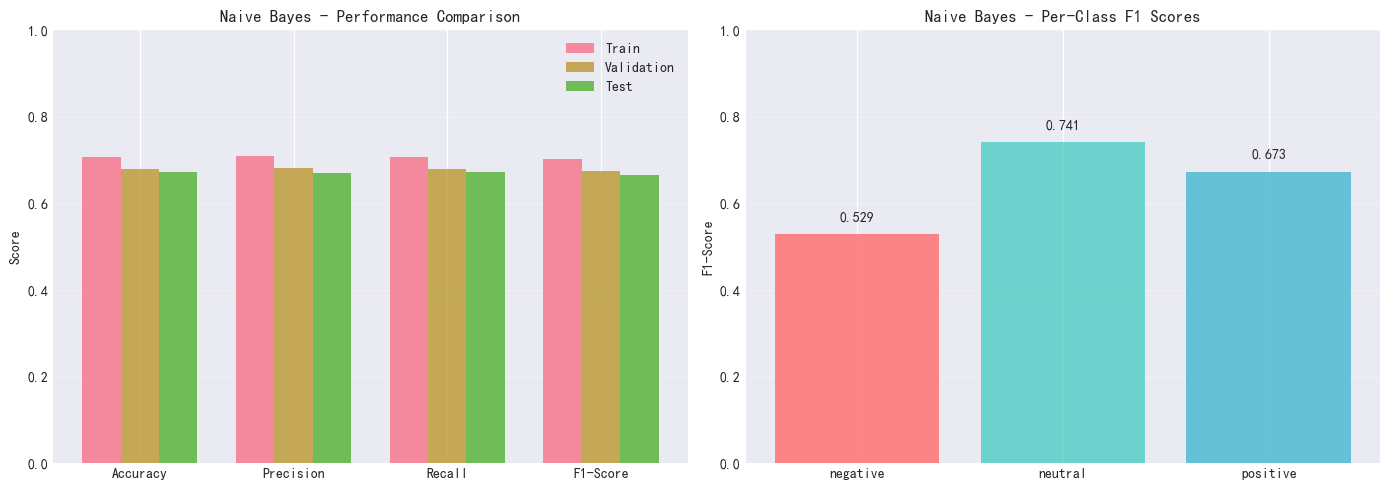

✓ Performance metrics saved


In [24]:
# Performance comparison visualization
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_vals = [train_metrics[m] for m in metrics_names]
val_vals = [val_metrics[m] for m in metrics_names]
test_vals = [test_metrics[m] for m in metrics_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison across datasets
x = np.arange(len(metrics_names))
width = 0.25

axes[0].bar(x - width, train_vals, width, label='Train', alpha=0.8)
axes[0].bar(x, val_vals, width, label='Validation', alpha=0.8)
axes[0].bar(x + width, test_vals, width, label='Test', alpha=0.8)
axes[0].set_ylabel('Score')
axes[0].set_title('Naive Bayes - Performance Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Per-class F1 scores
f1_per_class = f1_score(y_test, y_test_pred, average=None, zero_division=0)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[1].bar(label_names, f1_per_class, color=colors, alpha=0.8)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Naive Bayes - Per-Class F1 Scores', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(f1_per_class):
    axes[1].text(i, v + 0.03, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(str(results_dir / 'metrics_naive_bayes.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Performance metrics saved")

In [25]:
# Per-class detailed analysis
print("\nPer-Class Analysis:")
print("="*50)

for i, label in enumerate(label_names):
    mask = y_test == i
    if mask.sum() == 0:
        continue
    
    tp = ((y_test == i) & (y_test_pred == i)).sum()
    fp = ((y_test != i) & (y_test_pred == i)).sum()
    fn = ((y_test == i) & (y_test_pred != i)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{label.upper()}: TP={tp}, FP={fp}, FN={fn}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Per-Class Analysis:

NEGATIVE: TP=314, FP=199, FN=361
  Precision: 0.6121, Recall: 0.4652, F1: 0.5286

NEUTRAL: TP=912, FP=451, FN=185
  Precision: 0.6691, Recall: 0.8314, F1: 0.7415

POSITIVE: TP=750, FP=312, FN=416
  Precision: 0.7062, Recall: 0.6432, F1: 0.6732


## 4. Feature Importance Analysis

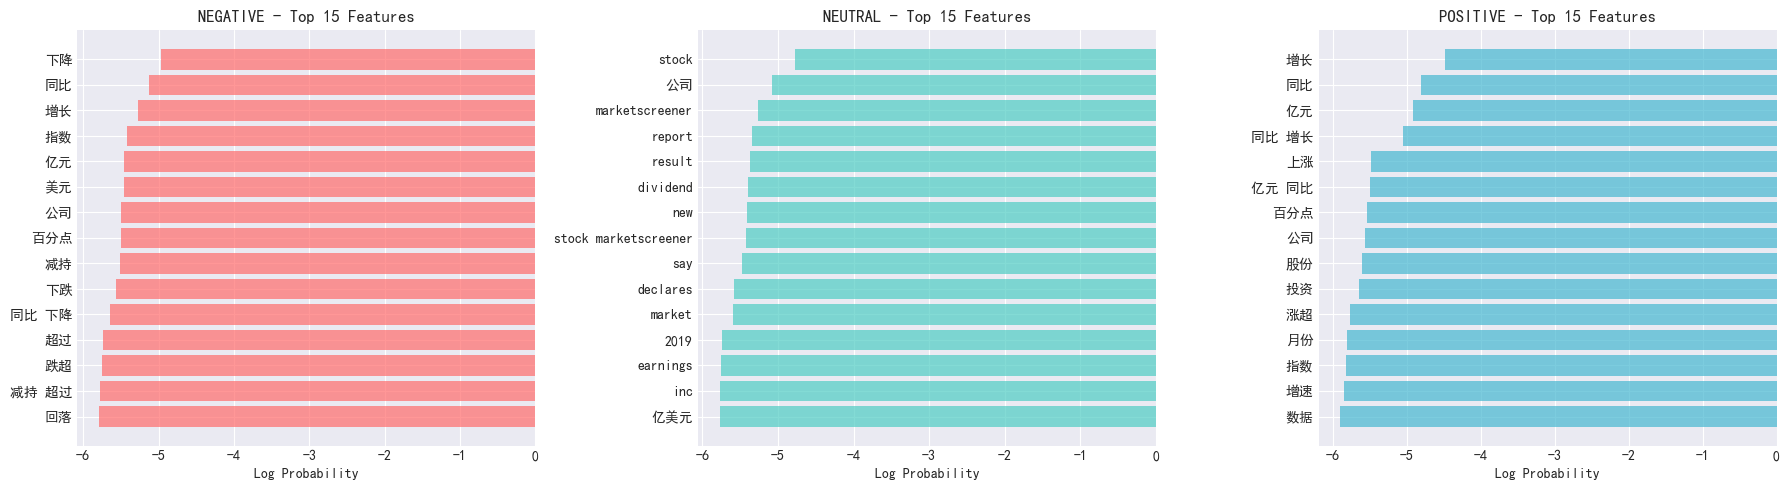

✓ Feature importance analysis saved


In [26]:
# Extract and visualize top features per class
tfidf_vectorizer = joblib.load(str(project_root / 'models' / 'tfidf_vectorizer.pkl'))
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, label in enumerate(label_names):
    feature_log_prob = best_model.feature_log_prob_[i]
    
    top_indices = np.argsort(feature_log_prob)[-15:][::-1]
    top_features = feature_names[top_indices]
    top_scores = feature_log_prob[top_indices]
    
    axes[i].barh(top_features, top_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'][i], alpha=0.7)
    axes[i].set_xlabel('Log Probability')
    axes[i].set_title(f'{label.upper()} - Top 15 Features', fontsize=12, fontweight='bold')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig(str(results_dir / 'top_features_naive_bayes.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance analysis saved")

## 5. Prediction Examples & Error Analysis

In [27]:
# Load original test data
data_dir = project_root / 'data' / 'train_test'
if not data_dir.exists():
    data_dir = project_root.parent / 'data' / 'train_test'

test_df = pd.read_csv(str(data_dir / 'test.csv'))

# Add predictions
test_df['predicted'] = label_encoder.inverse_transform(y_test_pred)
test_df['predicted_proba_max'] = y_test_proba.max(axis=1)

print(f"✓ Test data loaded: {len(test_df)} samples")

✓ Test data loaded: 2938 samples


In [28]:
# High confidence correct predictions
correct_mask = (test_df['sentiment_normalized'] == test_df['predicted'])

print("\nHigh Confidence Correct Predictions (Top 3):")
print("="*50)

high_conf_correct = test_df[correct_mask].nlargest(3, 'predicted_proba_max')
for idx, row in high_conf_correct.iterrows():
    print(f"\nText: {row['text'][:80]}...")
    print(f"Sentiment: {row['sentiment_normalized']} | Confidence: {row['predicted_proba_max']:.4f}")


High Confidence Correct Predictions (Top 3):

Text: Edited Transcript of AKBA earnings conference call or presentation 12-Nov-19 2:0...
Sentiment: neutral | Confidence: 1.0000

Text: Edited Transcript of SBPH earnings conference call or presentation 11-Nov-19 9:3...
Sentiment: neutral | Confidence: 1.0000

Text: Edited Transcript of GFF earnings conference call or presentation 13-Nov-19 9:30...
Sentiment: neutral | Confidence: 1.0000


In [29]:
# Incorrect predictions
incorrect_mask = (test_df['sentiment_normalized'] != test_df['predicted'])

print("\nIncorrect Predictions (Top 3):")
print("="*50)

low_conf_incorrect = test_df[incorrect_mask].head(3)
for idx, row in low_conf_incorrect.iterrows():
    print(f"\nText: {row['text'][:80]}...")
    print(f"True: {row['sentiment_normalized']} | Predicted: {row['predicted']} (Conf: {row['predicted_proba_max']:.4f})")


Incorrect Predictions (Top 3):

Text: $GE - GE Is A Buy, Considering Patent Dynamics. Subscribe to Seeking Alpha for m...
True: positive | Predicted: neutral (Conf: 0.9929)

Text: 2021年4月份，中部地区规模以上工业增加值同比增长9.3%，增速同比提高4.8个百分点，比上月回落12.9个百分点。6个省份同比均增长，增幅较大的安徽、山西分...
True: positive | Predicted: negative (Conf: 0.5965)

Text: 1月份，国内棉花期现货价格在国际棉价带动下再次上涨。1月26日，郑州商品交易所棉花期货主力合约结算价21700元/吨，环比上涨1700元/吨，涨幅8.5%；代表...
True: positive | Predicted: negative (Conf: 0.6317)


In [30]:
# Error analysis statistics
print(f"\nPrediction Statistics:")
print(f"  Correct: {correct_mask.sum()}/{len(test_df)} ({correct_mask.sum()/len(test_df)*100:.1f}%)")
print(f"  Incorrect: {incorrect_mask.sum()}/{len(test_df)} ({incorrect_mask.sum()/len(test_df)*100:.1f}%)")

print(f"\nError breakdown:")
error_df = test_df[incorrect_mask]
for true_label in label_names:
    for pred_label in label_names:
        if true_label != pred_label:
            count = ((error_df['sentiment_normalized'] == true_label) & 
                    (error_df['predicted'] == pred_label)).sum()
            if count > 0:
                print(f"  {true_label} -> {pred_label}: {count}")


Prediction Statistics:
  Correct: 1976/2938 (67.3%)
  Incorrect: 962/2938 (32.7%)

Error breakdown:
  negative -> neutral: 183
  negative -> positive: 178
  neutral -> negative: 51
  neutral -> positive: 134
  positive -> negative: 148
  positive -> neutral: 268


## 6. Save Model Results

In [31]:
# Save model results
results = {
    'model_name': 'Naive Bayes + TF-IDF',
    'alpha': best_alpha,
    'train_metrics': train_metrics,
    'val_metrics': val_metrics,
    'test_metrics': test_metrics,
    'confusion_matrix': cm.tolist()
}

import json
results_dir = project_root / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

with open(str(results_dir / 'naive_bayes_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

test_df.to_csv(str(results_dir / 'naive_bayes_predictions.csv'), index=False)

print("✓ Results saved to results/")

✓ Results saved to results/


In [32]:
# Final summary
print("\n" + "="*60)
print("Naive Bayes Model Summary")
print("="*60)
print(f"""
Model Configuration:
  - Algorithm: Multinomial Naive Bayes
  - Features: TF-IDF (max_features=5000, ngram=1-2)
  - Best alpha: {best_alpha}

Test Set Performance:
  - Accuracy:  {test_metrics['Accuracy']:.4f}
  - Precision: {test_metrics['Precision']:.4f}
  - Recall:    {test_metrics['Recall']:.4f}
  - F1-Score:  {test_metrics['F1-Score']:.4f}

Model Characteristics:
  ✓ Fast training
  ✓ Low memory usage
  ✓ Stable performance
  ✓ Highly interpretable (clear feature importance)

✓ Model and results saved successfully
""")


Naive Bayes Model Summary

Model Configuration:
  - Algorithm: Multinomial Naive Bayes
  - Features: TF-IDF (max_features=5000, ngram=1-2)
  - Best alpha: 0.05

Test Set Performance:
  - Accuracy:  0.6726
  - Precision: 0.6707
  - Recall:    0.6726
  - F1-Score:  0.6655

Model Characteristics:
  ✓ Fast training
  ✓ Low memory usage
  ✓ Stable performance
  ✓ Highly interpretable (clear feature importance)

✓ Model and results saved successfully

